---

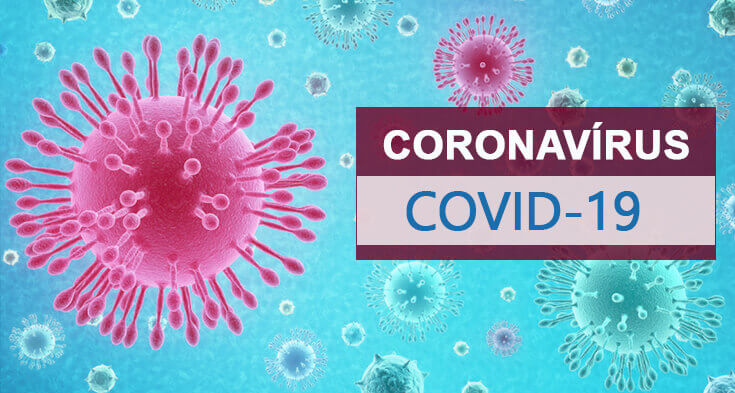

## 1\. Introdução

### **1.1. TLDR**

 - **Dashboard**:
  - Google Data Studio (https://lookerstudio.google.com/reporting/5c6938c2-abc5-4cb7-85ca-c39d88ccf726).

 - **Fontes**:
  - Casos pela universidade John Hopkins ([link](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports));
  - Vacinação pela universidade de Oxford ([link](https://covid.ourworldindata.org/data/owid-covid-data.csv)).

### **1.2. Pandemia Coronavírus 2019**

 A COVID-19 é uma infecção respiratória aguda causada pelo coronavírus SARS-CoV-2, potencialmente grave, de elevada transmissibilidade e de distribuição global. Fonte: Governo brasileiro ([link](https://www.gov.br/saude/pt-br/coronavirus/o-que-e-o-coronavirus)).

A disponibilidade de dados sobre a evolução da pandemia no tempo em uma determinada região geográfica é fundamental para o seu combate! Este projeto busca construir um dashboard de dados para exploração e visualização interativa de dados sobre o avanço de casos e da vacinação do Brasil.

### **1.3. Dados**

Os dados sobre **casos da COVID-19** são compilados pelo centro de ciência de sistemas e engenharia da universidade americana **John Hopkins** ([link](https://www.jhu.edu)). Os dados são atualizados diariamente deste janeiro de 2020 com uma granularidade temporal de dias e geográfica de regiões de países (estados, condados, etc.). O website do projeto pode ser acessado neste [link](https://systems.jhu.edu/research/public-health/ncov/) enquanto os dados, neste [link](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports). Abaixo estão descritos os dados derivados do seu processamento.

 - **date**: data de referência;
 - **state**: estado;
 - **country**: país;
 - **population**: população estimada;
 - **confirmed**: número acumulado de infectados;
 - **confirmed_1d**: número diário de infectados;
 - **confirmed_moving_avg_7d**: média móvel de 7 dias do número diário de infectados;
 - **confirmed_moving_avg_7d_rate_14d**: média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
 - **deaths**: número acumulado de mortos;
 - **deaths_1d**: número diário de mortos;
 - **deaths_moving_avg_7d**: média móvel de 7 dias do número diário de mortos;
 - **deaths_moving_avg_7d**: média móvel de 7 dias dividido pela média móvel de 7 dias de 14 dias atrás;
 - **month**: mês de referência;
 - **year**: ano de referência.

Os dados sobre **vacinação da COVID-19** são compilados pelo projeto Nosso Mundo em Dados (*Our World in Data* ou OWID) da universidade britânica de **Oxford** ([link](https://www.ox.ac.uk)). Os dados são **atualizados diariamente** deste janeiro de 2020 com uma **granularidade temporal de dias e geográfica de países**. O website do projeto pode ser acessado neste [link](https://ourworldindata.org) enquanto os dados, neste [link](https://covid.ourworldindata.org/data/owid-covid-data.csv). Abaixo estão descritos os dados derivados do seu processamento.

 - **date**: data de referência;
 - **country**: país;
 - **population**: população estimada;
 - **total**: número acumulado de doses administradas;
 - **one_shot**: número acumulado de pessoas com uma dose;
 - **one_shot_perc**: número acumulado relativo de pessoas com uma dose;
 - **two_shots**: número acumulado de pessoas com duas doses;
 - **two_shot_perc**: número acumulado relativo de pessoas com duas doses;
 - **three_shots**: número acumulado de pessoas com três doses;
 - **three_shot_perc**: número acumulado relativo de pessoas com três doses;
 - **month**: mês de referência;
 - **year**: ano de referência.

## 2\. Análise Exploratória de Dados

Nesta sessão vamos utilizar os seguintes pacotes Python para processar os dados bruto em um formato adequado para um painel para exploração interativa de dados.

In [46]:
import math
from typing import Iterator
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

### **2.1. Casos**

Vamos processar os dados de **casos** da universidade John Hopkins.



#### **2.1.1. Extração**

O dado está compilado em um arquivo por dia, exemplo para 2021/12/01.

In [47]:
cases = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/01-12-2021.csv', sep=',')

In [48]:
cases.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2021-01-13 05:22:15,33.93911,67.709953,53584,2301,44608,6675,Afghanistan,137.647787,4.294192
1,NaN,NaN,NaN,Albania,2021-01-13 05:22:15,41.15330,20.168300,64627,1252,38421,24954,Albania,2245.708527,1.937271
2,NaN,NaN,NaN,Algeria,2021-01-13 05:22:15,28.03390,1.659600,102641,2816,69608,30217,Algeria,234.067409,2.743543
3,NaN,NaN,NaN,Andorra,2021-01-13 05:22:15,42.50630,1.521800,8682,86,7930,666,Andorra,11236.653077,0.990555
4,NaN,NaN,NaN,Angola,2021-01-13 05:22:15,-11.20270,17.873900,18343,422,15512,2409,Angola,55.811022,2.300605


Portanto, precisaremos iterar dentro de um intervalo de tempo definido para extraí-lo.

In [49]:
def date_range(start_date: datetime, end_date: datetime) -> Iterator[datetime]:

    # Calcula o número de dias entre as datas de início e fim.
    date_range_days: int = (end_date - start_date).days

    # Itera sobre cada dia dentro do intervalo.
    for lag in range(date_range_days):

    # Calcula a próxima data somando o deslocamento `lag` (em dias) à data de início.
        yield start_date + timedelta(lag)

In [50]:
start_date = datetime(2021,  1,  1)
end_date   = datetime(2021, 12, 31)

De maneira iterativa, vamos selecionar as colunas de interesse e as linhas referentes ao Brasil.

In [51]:
# Criamos uma variável vazia, para armazenamento
cases = None
cases_is_empty = True

# intervalo de datas,  definidas pelas variáveis `start_date` e `end_date`.
for date in date_range(start_date=start_date, end_date=end_date):

    date_str = date.strftime('%m-%d-%Y') # data no formato mês-dia-ano

    # Construção da URL para acessar o arquivo CSV com os dados diários de COVID-19
    data_source_url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{date_str}.csv'

    case = pd.read_csv(data_source_url, sep=',') # Lê arquivo csv da url em df

    #Remove colunas
    case = case.drop(['FIPS', 'Admin2', 'Last_Update', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Case_Fatality_Ratio'], axis=1)

    # Iremos filtrar apenas os dados do Brazil
    case = case.query('Country_Region == "Brazil"').reset_index(drop=True)

    # Adicionamos uma nova coluna do tipo Date com formado Ano-Mês-Dia
    case['Date'] = pd.to_datetime(date.strftime('%Y-%m-%d'))

# Se cases estiver vazio
    if cases_is_empty:

# Adiciona`case` (os primeiros casos) a `cases`.
        cases = case

       #  `cases_is_empty` define False, pois `cases` não está  vazio.
        cases_is_empty = False

      # concatena o df case(dados atuais) com o df cases
    else:
        cases = pd.concat([cases, case], ignore_index=True)


In [52]:
cases.query('Province_State == "Sao Paulo"').head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
24,Sao Paulo,Brazil,1466191,46775,3192.990778,2021-01-01
51,Sao Paulo,Brazil,1467953,46808,3196.827966,2021-01-02
78,Sao Paulo,Brazil,1471422,46845,3204.382565,2021-01-03
105,Sao Paulo,Brazil,1473670,46888,3209.278136,2021-01-04
132,Sao Paulo,Brazil,1486551,47222,3237.329676,2021-01-05


#### **2.1.2. Wrangling**

Vamos manipular os dados para o dashboard. O foco é em garantir uma boa granularidade e qualidade da base de dados.

In [53]:
cases.head()

,Province_State,Country_Region,Confirmed,Deaths,Incident_Rate,Date
0,Acre,Brazil,41689,796,4726.992352,2021-01-01
1,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01
2,Amapa,Brazil,68361,926,8083.066602,2021-01-01
3,Amazonas,Brazil,201574,5295,4863.536793,2021-01-01
4,Bahia,Brazil,494684,9159,3326.039611,2021-01-01


In [54]:
# Verificamos o tamanho do DataFrame
cases.shape

(9828, 6)

In [55]:
#Verificamos as informações do DataFrame
cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9828 entries, 0 to 9827
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province_State  9828 non-null   object        
 1   Country_Region  9828 non-null   object        
 2   Confirmed       9828 non-null   int64         
 3   Deaths          9828 non-null   int64         
 4   Incident_Rate   9828 non-null   float64       
 5   Date            9828 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 460.8+ KB


Começamos com o nome das colunas.

In [56]:
# Renomeamos a coluna Province_State e Country_Region no DataFrame Cases
cases = cases.rename(
  columns={
    'Province_State': 'state',
    'Country_Region': 'country'
  }
)

# Percorremos pelas colunas do DataFrame
for col in cases.columns:

# Renomeamos as colunas para todas ficar minusculas
  cases = cases.rename(columns={col: col.lower()})

In [57]:
cases.head(10)

,state,country,confirmed,deaths,incident_rate,date
0,Acre,Brazil,41689,796,4726.992352,2021-01-01
1,Alagoas,Brazil,105091,2496,3148.928928,2021-01-01
2,Amapa,Brazil,68361,926,8083.066602,2021-01-01
3,Amazonas,Brazil,201574,5295,4863.536793,2021-01-01
4,Bahia,Brazil,494684,9159,3326.039611,2021-01-01
5,Ceara,Brazil,336504,10004,3679.250221,2021-01-01
6,Distrito Federal,Brazil,252077,4263,8360.019740,2021-01-01
7,Espirito Santo,Brazil,249271,5093,6202.580469,2021-01-01
8,Goias,Brazil,309191,6805,4404.337541,2021-01-01
9,Maranhao,Brazil,200959,4506,2840.337230,2021-01-01


Ajustamos o nome dos estados.

In [58]:
states_map = {
    'Amapa': 'Amapá',
    'Ceara': 'Ceará',
    'Espirito Santo': 'Espírito Santo',
    'Goias': 'Goiás',
    'Para': 'Pará',
    'Paraiba': 'Paraíba',
    'Parana': 'Paraná',
    'Piaui': 'Piauí',
    'Rondonia': 'Rondônia',
    'Sao Paulo': 'São Paulo'
}

cases['state'] = cases['state'].apply(lambda state: states_map.get(state) if state in states_map.keys() else state)

Vamos então computar novas colunas para enriquecer a base de dados.

 - Chaves temporais:

In [59]:
cases['month'] = cases['date'].apply(lambda date: date.strftime('%Y-%m'))
cases['year']  = cases['date'].apply(lambda date: date.strftime('%Y'))

 - População estimada do estado:

In [60]:
cases['population'] = round(100000 * (cases['confirmed'] / cases['incident_rate']))
cases = cases.drop('incident_rate', axis=1)

 - Número, média móvel (7 dias) e estabilidade (14 dias) de casos e mortes por estado:

| 1 | 2 | 3 | 4 | 5 | 6 | <font color='red'>7</font> | <font color='green'>8</font> | 9 | 10 | 11 | 12 | 13 | <font color='blue'>14<font color='red'> | 15 | 16 | 17 | 18 | 19 | 20 | 21 |
| - | - | - | - | - | - | - | - | - | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- | -- |
| <font color='red'>D-6</font> | <font color='red'>D-5</font> | <font color='red'>D-4</font> | <font color='red'>D-3</font> | <font color='red'>D-2</font> | <font color='red'>D-1</font> | <font color='red'>D0</font> | | | | | | | | | | | | | | |
| D-7 | <font color='green'>D-6</font> | <font color='green'>D-5</font> | <font color='green'>D-4</font> | <font color='green'>D-3</font> | <font color='green'>D-2</font> | <font color='green'>D-1</font> | <font color='green'>D0</font> | | | | | | | | | | | | | |
| D-13 | D-12 | D-11 | D-10 | D-9 | D-8 | D-7 | <font color='blue'>D-6</font> | <font color='blue'>D-5</font> | <font color='blue'>D-4</font> | <font color='blue'>D-3</font> | <font color='blue'>D-2</font> | <font color='blue'>D-1</font> | <font color='blue'>D0</font> | | | | | | | |

In [61]:
# Variaveis para armazenamento
cases_ = None
cases_is_empty = True

# Criamos uma função para determinar a mundaça a tendência , a taxa de mudança, taxa: Pra baixo, Pra cima, Estável

def get_trend(rate: float) -> str:

  if np.isnan(rate):
    return np.NaN

  if rate < 0.75:
    status = 'downward' # Para Baixo
  elif rate > 1.15:
    status = 'upward'# Para Cima
  else:
    status = 'stable' # Estável

  return status


for state in cases['state'].drop_duplicates():

# Filtro para o estado atual
  cases_per_state = cases.query(f'state == "{state}"').reset_index(drop=True)
  cases_per_state = cases_per_state.sort_values(by=['date'])

# Média móvel de casos covid confirmados
  cases_per_state['confirmed_1d'] = cases_per_state['confirmed'].diff(periods=1) # Casos Confirmado nas 24h
  cases_per_state['confirmed_moving_avg_7d'] = np.ceil(cases_per_state['confirmed_1d'].rolling(window=7).mean()) # Média de Casos conformados nos últimos 7 dias
  cases_per_state['confirmed_moving_avg_7d_rate_14d'] = cases_per_state['confirmed_moving_avg_7d']/cases_per_state['confirmed_moving_avg_7d'].shift(periods=14) # Taxa de 14 dias
  cases_per_state['confirmed_trend'] = cases_per_state['confirmed_moving_avg_7d_rate_14d'].apply(get_trend)

# Médias móves para mortes
  cases_per_state['deaths_1d'] = cases_per_state['deaths'].diff(periods=1)
  cases_per_state['deaths_moving_avg_7d'] = np.ceil(cases_per_state['deaths_1d'].rolling(window=7).mean())
  cases_per_state['deaths_moving_avg_7d_rate_14d'] = cases_per_state['deaths_moving_avg_7d']/cases_per_state['deaths_moving_avg_7d'].shift(periods=14)
  cases_per_state['deaths_trend'] = cases_per_state['deaths_moving_avg_7d_rate_14d'].apply(get_trend)

 # Concatena os dados do estado ao conjunto de dados final
  if cases_is_empty:
    cases_ = cases_per_state
    cases_is_empty = False
  else:
    cases_ = pd.concat([cases_, cases_per_state], ignore_index=True)

cases = cases_
cases_ = None

Garantir o tipo do dado é fundamental para consistência da base de dados. Vamos fazer o *type casting* das colunas.

In [62]:
cases['population'] = cases['population'].astype('Int64')
cases['confirmed_1d'] = cases['confirmed_1d'].astype('Int64')
cases['confirmed_moving_avg_7d'] = cases['confirmed_moving_avg_7d'].astype('Int64')
cases['deaths_1d'] = cases['deaths_1d'].astype('Int64')
cases['deaths_moving_avg_7d'] = cases['deaths_moving_avg_7d'].astype('Int64')

Por fim, vamos reorganizar as colunas e conferir o resultado final.

In [63]:
cases = cases[['date', 'country', 'state', 'population', 'confirmed', 'confirmed_1d', 'confirmed_moving_avg_7d', 'confirmed_moving_avg_7d_rate_14d', 'confirmed_trend', 'deaths', 'deaths_1d', 'deaths_moving_avg_7d', 'deaths_moving_avg_7d_rate_14d', 'deaths_trend', 'month', 'year']]

In [64]:
cases.head(n=25)

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,date,country,state,population,confirmed,confirmed_1d,confirmed_moving_avg_7d,confirmed_moving_avg_7d_rate_14d,confirmed_trend,deaths,deaths_1d,deaths_moving_avg_7d,deaths_moving_avg_7d_rate_14d,deaths_trend,month,year
0,2021-01-01,Brazil,Acre,881935,41689,<NA>,<NA>,NaN,NaN,796,<NA>,<NA>,NaN,NaN,2021-01,2021
1,2021-01-02,Brazil,Acre,881935,41941,252,<NA>,NaN,NaN,798,2,<NA>,NaN,NaN,2021-01,2021
2,2021-01-03,Brazil,Acre,881935,42046,105,<NA>,NaN,NaN,802,4,<NA>,NaN,NaN,2021-01,2021
3,2021-01-04,Brazil,Acre,881935,42117,71,<NA>,NaN,NaN,806,4,<NA>,NaN,NaN,2021-01,2021
4,2021-01-05,Brazil,Acre,881935,42170,53,<NA>,NaN,NaN,808,2,<NA>,NaN,NaN,2021-01,2021
5,2021-01-06,Brazil,Acre,881935,42378,208,<NA>,NaN,NaN,814,6,<NA>,NaN,NaN,2021-01,2021
6,2021-01-07,Brazil,Acre,881935,42478,100,<NA>,NaN,NaN,821,7,<NA>,NaN,NaN,2021-01,2021
7,2021-01-08,Brazil,Acre,881935,42814,336,161,NaN,NaN,823,2,4,NaN,NaN,2021-01,2021
8,2021-01-09,Brazil,Acre,881935,42908,94,139,NaN,NaN,823,0,4,NaN,NaN,2021-01,2021
9,2021-01-10,Brazil,Acre,881935,43127,219,155,NaN,NaN,825,2,4,NaN,NaN,2021-01,2021


#### **2.1.3. Carregamento**

Com os dados manipulados, vamos persisti-lo em disco, fazer o seu download e carrega-lo no Google Data Studio.

In [65]:
cases.to_csv('./covid-cases.csv', sep=',', index=False)

### **2.2. Vacinação**

Vamos processar os dados de **vacinação** da universidade de Oxford.

#### **2.2.1. Extração**

Os dados estão compilados em um único arquivo.

In [66]:
vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)

<ipython-input-66-608e6d2dd56d>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  vaccines = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', sep=',', parse_dates=[3], infer_datetime_format=True)


In [67]:
vaccines.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,0.0,0.0,NaN,0.0,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772,NaN,NaN,NaN,NaN


Vamos selecionar as colunas de interesse e as linhas referentes ao Brasil.

In [68]:
vaccines = vaccines.query('location == "Brazil"').reset_index(drop=True)
vaccines = vaccines[['location', 'population', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'date']]

In [69]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-06
2,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-07
3,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-08
4,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-09


#### **2.2.2. Wrangling**

Vamos manipular os dados para o dashboard. O foco é em garantir uma boa granularidade e qualidade da base de dados.

In [70]:
vaccines.head()

,location,population,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,date
0,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-05
1,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-06
2,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-07
3,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-08
4,Brazil,215313504,NaN,NaN,NaN,NaN,2020-01-09


In [71]:
vaccines.shape

(1674, 7)

In [72]:
vaccines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   location                 1674 non-null   object        
 1   population               1674 non-null   int64         
 2   total_vaccinations       695 non-null    float64       
 3   people_vaccinated        691 non-null    float64       
 4   people_fully_vaccinated  675 non-null    float64       
 5   total_boosters           455 non-null    float64       
 6   date                     1674 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 91.7+ KB


Vamos começar tratando os dados faltantes, a estratégia será a de preencher os buracos com o valor anterior válido mais próximo.

In [73]:
vaccines = vaccines.fillna(method='ffill')

<ipython-input-73-274988f553eb>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vaccines = vaccines.fillna(method='ffill')


Vamos também filtrar a base de dados de acordo com a coluna `date` para garantir que ambas as bases de dados tratam do mesmo período de tempo.

In [74]:
vaccines = vaccines[(vaccines['date'] >= '2021-01-01') & (vaccines['date'] <= '2021-12-31')].reset_index(drop=True)

Agora, vamos alterar o nome das colunas.

In [75]:
vaccines = vaccines.rename(
  columns={
    'location': 'country',
    'total_vaccinations': 'total',
    'people_vaccinated': 'one_shot',
    'people_fully_vaccinated': 'two_shots',
    'total_boosters': 'three_shots',
  }
)

Vamos então computar novas colunas para enriquecer a base de dados.

 - Chaves temporais:

In [76]:
vaccines['month'] = vaccines['date'].apply(lambda date: date.strftime('%Y-%m'))
vaccines['year']  = vaccines['date'].apply(lambda date: date.strftime('%Y'))

 - Dados relativos:

In [77]:
vaccines['one_shot_perc'] = round(vaccines['one_shot'] / vaccines['population'], 4)
vaccines['two_shots_perc'] = round(vaccines['two_shots'] / vaccines['population'], 4)
vaccines['three_shots_perc'] = round(vaccines['three_shots'] / vaccines['population'], 4)

Garantir o tipo do dado é fundamental para consistência da base de dados. Vamos fazer o *type casting* das colunas.

In [78]:
vaccines['population'] = vaccines['population'].astype('Int64')
vaccines['total'] = vaccines['total'].astype('Int64')
vaccines['one_shot'] = vaccines['one_shot'].astype('Int64')
vaccines['two_shots'] = vaccines['two_shots'].astype('Int64')
vaccines['three_shots'] = vaccines['three_shots'].astype('Int64')

Por fim, vamos reorganizar as colunas e conferir o resultado final.

In [79]:
vaccines = vaccines[['date', 'country', 'population', 'total', 'one_shot', 'one_shot_perc', 'two_shots', 'two_shots_perc', 'three_shots', 'three_shots_perc', 'month', 'year']]

In [80]:
vaccines.tail()

,date,country,population,total,one_shot,one_shot_perc,two_shots,two_shots_perc,three_shots,three_shots_perc,month,year
360,2021-12-27,Brazil,215313504,329011365,165952037,0.7707,142764283,0.6631,25218893,0.1171,2021-12,2021
361,2021-12-28,Brazil,215313504,329861730,166062249,0.7713,142965728,0.6640,25758909,0.1196,2021-12,2021
362,2021-12-29,Brazil,215313504,330718457,166143380,0.7716,143282084,0.6655,26219623,0.1218,2021-12,2021
363,2021-12-30,Brazil,215313504,331164041,166185628,0.7718,143398692,0.6660,26507937,0.1231,2021-12,2021
364,2021-12-31,Brazil,215313504,331273910,166195505,0.7719,143436012,0.6662,26571077,0.1234,2021-12,2021


#### **2.2.3. Carregamento**

Com os dados manipulados, vamos persisti-lo em disco, fazer o seu download e carrega-lo no Google Data Studio.

In [81]:
vaccines.to_csv('./covid-vaccines.csv', sep=',', index=False)

## 3\. Exploração Interativa de Dados

### **3.1. KPIs**

O dashboard de dados contem os seguintes indicadores chaves de desempenho (*key performance indicator* ou KPI) consolidados:

1. Casos e mortes nas 24 horas;
1. Média móvel (7 dias) de casos e mortes;
1. Tendência de casos e mortes;
1. Proporção de vacinados com 1ª, 2ª e 3ª doses.

### **3.2. EDA**

O dashboard de dados contem os seguintes gráficos para a análise exploratória de dados (*exploratory data analysis*
ou EDA) interativa:

1. Distribuição do números de casos e mortes ao longo do tempo;
1. Distribuição da média móvel (7 dias) do números de casos e mortes ao longo do tempo;
1. Distribuição geográfica dos casos por estado por dia.

## 4\. Storytelling

Resumo : Dividimos o nosso trabalho em duas etapas :

**Primeiro** preparamos os dados no google colab em python , extração. manipulação
e carregamento dos dados. Casos de covid e vacinação.

**Segundo** Com os dados preparados importamos ele dentro do datastudio, criando nossas fontes de dados e nossos relatórios (dashbord).


